In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib notebook
from pylab import *

In [2]:
def create_wildfire_df(PATH):
    '''
    PATH: Linux path to sqlite for wildfire database
    Output:
        dataframe: of wildfire with the following columns:
        LATITUDE
        LONGITUDE
        STATE
        date
        fire_size
        fire_year
        fire_month
        fire_total (This is total fire in a particular latitude, longitude, fire_year and fire_month)
    '''
    assert(os.path.exists(PATH)),"Incorrect file path"
    conn = sqlite3.connect(PATH)
    data_dates = pd.read_sql_query("SELECT fire_year, discovery_date FROM fires;", conn)
    data_size = pd.read_sql_query("SELECT fire_size, fire_size_class FROM fires;", conn)
    data_location = pd.read_sql_query("SELECT latitude, longitude, state FROM fires;", conn)
    date = pd.read_sql_query("select datetime(DISCOVERY_DATE) as DISCOVERY_DATE from fires;", conn)
    data_dates_arr = date['DISCOVERY_DATE']
    fire_year_arr = data_dates['FIRE_YEAR']
    fire_size_arr = data_size['FIRE_SIZE']  
    #Create a dataframe df 
    df = data_location
    df['date'] = data_dates_arr
    df['fire_size'] = fire_size_arr
    df['fire_year'] = fire_year_arr
    df['fire_month'] = pd.DatetimeIndex(df['date']).month
    #Converted Lat and Long to int to remove the exact precision
    df['LATITUDE'] = df['LATITUDE'].round(2)
    df['LONGITUDE'] = df['LONGITUDE'].round(2)
##Compute total fire based on Latitude, Longitude, fire_year and fire_month
    df['fire_total'] = df.groupby(['LATITUDE','LONGITUDE', 'fire_year','fire_month'])['fire_size'].transform(sum)
    
    return df

In [3]:
def large_fire_coord(state, fire_size, df):
    '''
    Input: 
        state: The state we want to focus on.
        df: Input dataframe
        fire_size: fire size above which is considered large
    Output:
        lat_min,lat_max,long_min,long_max: the coordinates with fires above fire_size in state 'state'
    '''
    #print(state)
    df = df.query("fire_total >= fire_size and STATE == @state")
    lat_max = df['LATITUDE'].max()
    lat_min = df['LATITUDE'].min()
    long_max = df['LONGITUDE'].max()
    long_min = df['LONGITUDE'].min() 
    return lat_min,lat_max,long_min,long_max

In [4]:
PATH = '../../188-million-us-wildfires/FPA_FOD_20170508.sqlite'
fire_df = create_wildfire_df(PATH)

In [47]:
def process_df(coords, fire_size, df,year):
    '''
    Input: 
        coords: A tuple of lat_min,lat_max,long_min,long_max in which we need to find wild fires
        Find sum of fire occuring within the location, for a given year and month
    
    '''
    lat_min,lat_max,long_min,long_max = coords
    #print(lat_min,lat_max,long_min,long_max)
    df_new = df.query("LATITUDE >= @lat_min and LATITUDE <= @lat_max and LONGITUDE >= @long_min and LONGITUDE <= @long_max and fire_total>=@fire_size and fire_year == @year")
    return df_new

In [49]:
coords = large_fire_coord('AK',100,fire_df)
#fire_df_local = process_df(coords,100,fire_df,2004)

In [ ]:
#fire_sz= np.array(fire_df_local['fire_size'].to_list())

In [ ]:
#lat_fire = np.array(fire_df_local['LATITUDE'].tolist())
#lon_fire = np.array(fire_df_local['LONGITUDE'].tolist())+360

In [8]:
import os 
import numpy as np
import iris   
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline
import iris.coord_categorisation as cat
import pandas as pd
from iris.analysis import Aggregator

In [9]:
def region_based_cube(cube,coords):
    '''
    Inputs:
        cube with latitude and longitude as coords
        coords: the region we want to extract from input cube
    Outputs: 
        A smaller cube within coords
    '''
    lat_min,lat_max,long_min,long_max = coords
    lat_cons = iris.Constraint(latitude = lambda x : lat_min < x < lat_max)
    if (long_min<0):
        long_min = long_min+360
    if(long_max <0) :
        long_max = long_max+360
    long_cons = iris.Constraint(longitude = lambda x : long_min < x < long_max)
    new_cube = cube.extract(lat_cons & long_cons)
    return new_cube

In [10]:
def time_based_cube(cube,year):
    time_cons = iris.Constraint(year = year)
    new_cube = cube.extract(time_cons)
    return new_cube

In [11]:
##Adding auxilary axis:
def get_decade(coord, value):
    date = coord.units.num2date(value)
    return date.year - date.year % 10
def get_year(coord, value):
    date = coord.units.num2date(value)
    return date.year

def get_month(coord, value):
    date = coord.units.num2date(value)
    return date.month


In [50]:
PATH_temp = os.path.join(os.getcwd(), "../../air.mon.mean.nc")
cube_temp = iris.load_cube(PATH_temp)
cat.add_categorised_coord(cube_temp, 'year', 'time', get_year)
cat.add_categorised_coord(cube_temp, 'month', 'time', get_month)
cube_local = region_based_cube(cube_temp,coords)
cube_time = time_based_cube(cube_local,2004)

In [13]:
cube_mean = cube_time.collapsed(['month'], iris.analysis.MAX)

C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


In [51]:
lat = cube_mean.coord('latitude').points
lon = cube_mean.coord('longitude').points

In [59]:
fire_sz,lat_fire,lon_fire = get_local_fire(coords,100,fire_df,1993)

In [60]:
fire_sz.min()

110.0

In [16]:
data = cube_mean.data

In [61]:
def get_cube_data(cube,year):
    cube_time = time_based_cube(cube,year)
    print("CALLED",year)
    cube_mean = cube_time.collapsed(['month'], iris.analysis.MAX)
    lat = cube_mean.coord('latitude').points
    lon = cube_mean.coord('longitude').points
    return cube_mean.data,lat,lon

<IPython.core.display.Javascript object>


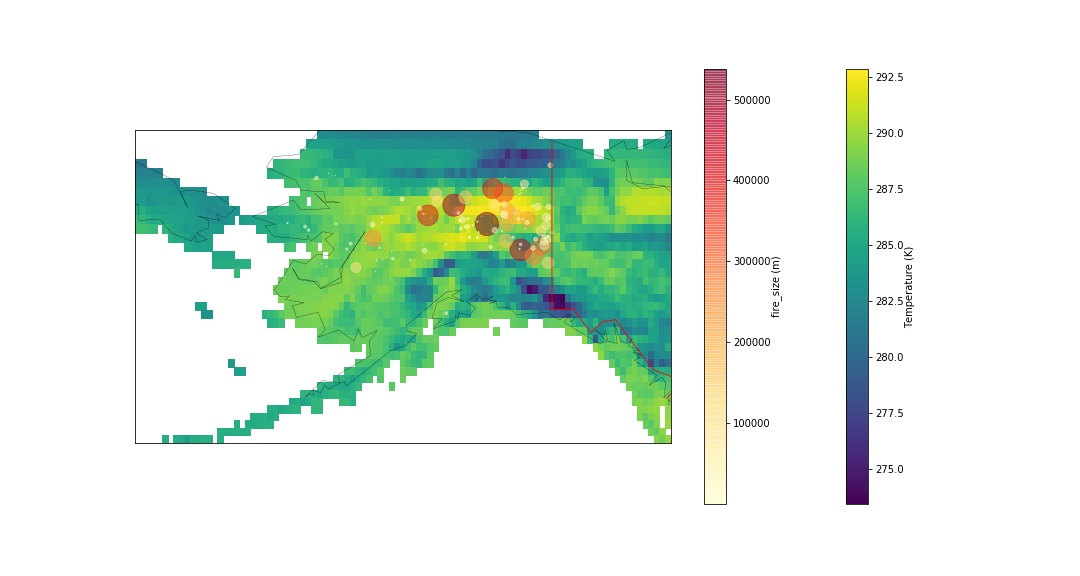

CALLED 2004
CS.. <class 'matplotlib.collections.QuadMesh'>


C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


In [62]:
##Plot showing temperature with wildfire size for 2004. 
##Size of circles denote and color denote area burnt due to wildfire.
%matplotlib notebook
year = 2004
plt.figure(figsize=[15,8])
#fig, ax = plt.subplots()
m=Basemap(projection='mill',lat_ts=10, \
  llcrnrlon=lon.min(),urcrnrlon=lon.max(), \
  llcrnrlat=lat.min(),urcrnrlat=lat.max(), \
  resolution='c')
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.85,color='red')
#xxx,yyy = meshgrid(lons,lats)
#x,y=m(xxx,yyy)
#print(y)
data,lat,lon=get_cube_data(cube_local,year)
Lon,Lat = meshgrid(lon,lat)
x, y = m(Lon,Lat)
cs = m.pcolormesh(x,y,data,shading='flat',cmap='viridis')
print("CS..",type(cs))
cbar= plt.colorbar()
cbar.set_label("Temperature (K)", labelpad=+1)
fire_sz,lat_fire,lon_fire = get_local_fire(coords,100,fire_df,year)
a,b = m(lon_fire,lat_fire)
scat = m.scatter(lon_fire, lat_fire, s=fire_sz/1000, latlon=True,
         c=fire_sz,cmap='YlOrRd',
          alpha=0.5)
cbar= plt.colorbar()
cbar.set_label("fire_size (m)", labelpad=+1)
plt.show()


# initial_year=int(2004)
# axamp = plt.axes([0.25, .03, 0.50, 0.02])
# print(axamp)
# # Slider
# samp = Slider(axamp, 'Amp', 1970, 2014, valinit=initial_year,valfmt="%i")

# def update(val):
#     # amp is the current value of the slider
#     amp = samp.val
#     print("CURREENNNNTTT",amp)
#     # update curve
#     data,lat,lon=get_cube_data(cube_local,amp)
#     Lon,Lat = meshgrid(lon,lat)
#     x, y = m(Lon,Lat)
#     inp = [x,y,data]
#     cs.set_ydata(inp)
#     cbar= plt.colorbar()
#     cbar.set_label("Temperature (K)", labelpad=+1)
#     #l.set_ydata(amp*np.sin(t))
#     # redraw canvas while idle
#     fig.canvas.draw_idle()
# samp.on_changed(update)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# #import matplotlib.animation as animation
# from matplotlib.widgets import Slider
# %matplotlib notebook
# #from ipywidgets import *

# TWOPI = 2*np.pi

# fig, ax = plt.subplots()

# t = np.arange(0.0, TWOPI, 0.001)
# initial_amp = .5
# s = initial_amp*np.sin(t)
# l, = plt.plot(t, s, lw=2)

# ax = plt.axis([0,TWOPI,-1,1])

# axamp = plt.axes([0.25, .03, 0.50, 0.02])
# print(axamp)
# # Slider
# samp = Slider(axamp, 'Amp', 0, 1, valinit=initial_amp)

# def update(val):
#     # amp is the current value of the slider
#     amp = samp.val
#     # update curve
    
#     l.set_ydata(amp*np.sin(t))
#     print("HERE")
#     # redraw canvas while idle
#     fig.canvas.draw_idle()

# # call update function on slider value change
# samp.on_changed(update)

# plt.show()

In [ ]:
# samp.on_changed(update)